<a href="https://colab.research.google.com/github/dkaratzas/XNAP_Profs/blob/main/W03_01_Intro_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple MLP in PyTorch

In this notebook we will detail how to create and train a multilayer perceptron using pytorch. We will go through:
 
1. Two different ways of creating an MLP
2. Create a standard training loop
3. Visualize results

In [ ]:
import torch #should be installed by default in any colab notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

plt.rcParams["figure.figsize"] = (20,10)

In [ ]:
# If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data

Before training we need data! So lets create an artificial dataset for our model to learn.


In [ ]:
#@title The code in this cell defines a function to generate training and validation data. Just hit the play button before continuing
def generate_data(n_samples, generator, regression=False, noise_scale=2, **kwargs):

    x_train, y_train = generator(n_samples, **kwargs) # training data

    if "noise" in kwargs:
        kwargs["noise"] *= noise_scale
    
    x_val, y_val = generator(n_samples, **kwargs)

    

    # Plot the data
    fig, ax = plt.subplots(1, 2)
    ax[0].set_title("Training Data") 
    ax[1].set_title("Validation Data")

    if regression:
        ax[0].scatter(x_train, y_train, cmap=plt.cm.coolwarm)
        ax[1].scatter(x_val, y_val, cmap=plt.cm.coolwarm)
    else:
        ax[0].scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=plt.cm.coolwarm)
        ax[1].scatter(x_val[:, 0], x_val[:, 1], c=y_val, cmap=plt.cm.coolwarm)


    return x_train, y_train, x_val, y_val

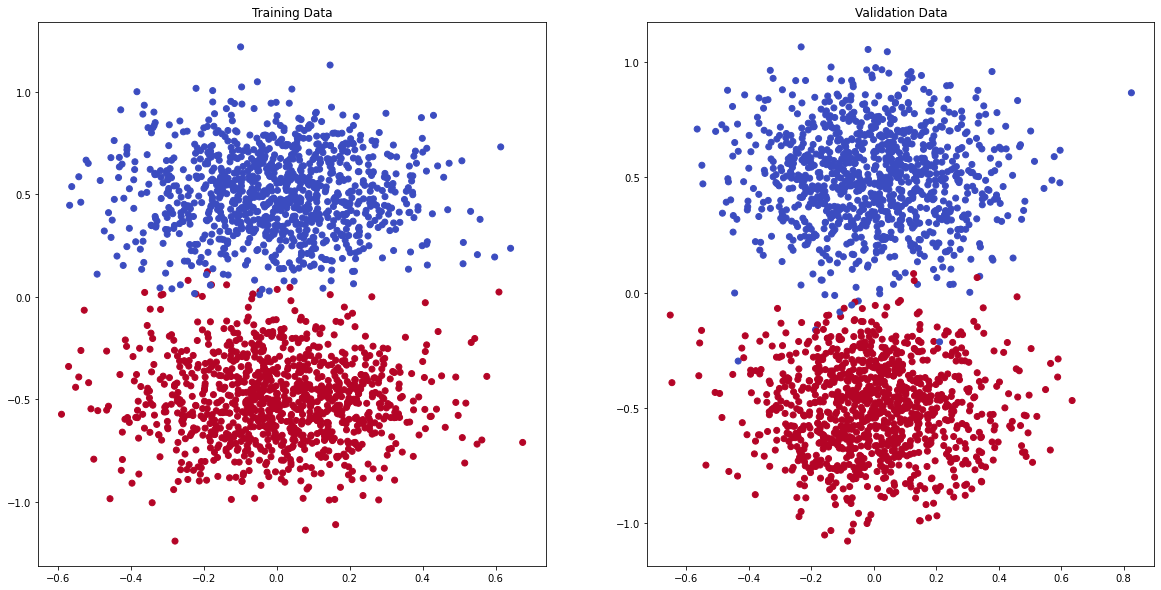

In [ ]:
# find more datasets at https://scikit-learn.org/stable/modules/classes.html#samples-generator
from sklearn.datasets import make_blobs
plt.rcParams["figure.figsize"] = (20,10)

N = 1000 # number of sample
x_train, y_train, x_val, y_val = generate_data([N, N], make_blobs, centers=[[0, 0.5], [0, -0.5]], cluster_std=0.2)

#Convert the data from numpy arrays into PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train)
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val)

# move data to gpu if available
x_train = x_train.to(device)
y_train = y_train.to(device)

x_val = x_val.to(device)
y_val = y_val.to(device)

In [ ]:
#@title The code in this cell is just for visualization no need to worry about it. Just hit the play button before continuing { display-mode: "form" }
# Dont worry about the code in this cell it is 
# just for visualization purposes you dont need to understand or edit it yet
def plot_model(x, y, model, axis):

    mesh = torch.arange(-2, 2, 0.01)

    xx, yy = torch.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data.cuda().detach())
    Z = Z.max(1)[1].reshape(xx.shape)
    axis.contourf(xx, yy, Z.cpu(), cmap=plt.cm.coolwarm, alpha=0.3)
    axis.scatter(x[:, 0].cpu(), x[:, 1].cpu(), c=y.cpu(), s=20, cmap=plt.cm.coolwarm)
    axis.get_xaxis().set_ticks([])
    axis.get_yaxis().set_ticks([])


def plot_regressor(x, y, model, axis):
    
    with torch.no_grad():
        y_pred = model(x).detach()
    axis.scatter(x.cpu(), y.cpu())
    axis.plot(x.cpu(), y_pred.cpu(), 'r-', lw=5, label="Model Prediction")
    axis.get_xaxis().set_ticks([])
    axis.get_yaxis().set_ticks([])

def draw_plots(x, y, model, losses, visualize_surface, visualize_regressor):

    if visualize_surface and visualize_regressor:
        raise ValueError("Expected only one of 'visualize_error' or 'visualize_regressor' to be True.")

    if visualize_surface:
        fig, ax = plt.subplots(1, 2)
        ax[0].set_title("Output Space")
        ax[1].set_title("Losses")
        ax[1].plot(losses["train"], label="training loss")
        ax[1].plot(losses["val"], label="validation loss")
        ax[1].set_xlabel("Epoch")
        plot_model(x_val, y_val, model, ax[0])
    
    elif visualize_regressor:
        fig, ax = plt.subplots(1, 2)
        ax[0].set_title("Validation Data")
        ax[1].set_title("Losses")
        ax[1].plot(losses["train"], label="training loss")
        ax[1].plot(losses["val"], label="validation loss")
        ax[1].set_xlabel("Epoch")
        plot_regressor(x_val, y_val, model, ax[0])

    else:
        plt.plot(losses["train"], label="training loss")
        plt.plot(losses["val"], label="validation loss")
    
    plt.legend()
    plt.pause(0.000001)
    plt.show()   

Now that these basic concepts are out of the way and we have our data lets take a look at how to create a simple MLP in PyTorch

The ```torch.nn``` [package](https://pytorch.org/docs/stable/nn.html) is the one containing all of the neural network related layers, operations etc.

In order to create a simple MLP we can define a sequential module like so:



```
#1a forma de crear model MLP
import torch.nn as nn

model = nn.Sequential(nn.Linear(inp_dim, hidden_dim)
                      nn.ReLU(),
                      nn.Linear(hidden_dim, output_dim))
#aplicamos una capa Lineal, una Relu y otra capa Lineal
```
So now we can feed data into this model and the ```nn``` module will take care of the forward pass.

Some more complicated acrchitectures will require you to detail the forward pass of the model. This will require creating a class that inherits from ```nn.Module``` and define its ```forward``` and ```__init__``` methods.

```
#2a forma de crear model MLP
import torch.nn as nn

class SimpleMLP(nn.Module):

    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(inp_dim, hidden_dim),
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    
    def forward(self, x):

        out = self.fc1(x)
        out = torch.ReLU(out)

        return self.fc2(out)
```

Notice how this approach allows more flexibility since we can insert ANY python statement in the forward method, such as ```print```, ```if else```, etc.

Since our model for this first session is very simple we will use the first approach in this notebook, but we encourage you to try your own model using the second approach.




# Training Loop

In [ ]:
def validate(criterion, model):   #contrario al modo train

    # set model in evaluation mode
    model.eval()
    with torch.no_grad(): # do not compute gradients for validation
        y_pred = model(x_val)


    # compute loss and accuracy 
    _, predicted = torch.max(y_pred, 1)
    val_loss = criterion(y_pred.squeeze(), y_val)
    val_acc = (y_val == predicted).sum().float() / len(y_val)

    return val_loss, val_acc



# Training loop
def train(criterion, model, optimizer, epochs=300, visualize_surface=False, visualize_regressor=False):
    
    losses = {"train": [], "val": []}

    for t in range(epochs):
        
        # activate training mode
        model.train()
        
        # Feed forward to get the logits
        y_pred = model(x_train)   #se crea el grafo
    
        # Compute the loss and accuracy
        loss = criterion(y_pred.squeeze(), y_train)
        score, predicted = torch.max(y_pred, 1)
        train_acc = (y_train == predicted).sum().float() / len(y_train)
        print("Training: [EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), train_acc))
        losses["train"].append(loss)
        
        # zero the gradients before running
        # the backward pass.
        optimizer.zero_grad()   #ponemos las gradientes a 0
        
        # Backward pass to compute the gradient
        # of loss w.r.t our learnable params. 
        loss.backward()   #calculamos los gradientes (derivamos)

        # Update params
        optimizer.step()   #actualizamos los pesos basándose en los gradientes

        # Run model on validation data
        val_loss, val_acc = validate(criterion, model)
        print("Validation: [EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, val_loss.item(), val_acc))
        losses["val"].append(val_loss)

        display.clear_output(wait=True)

        draw_plots(x_val, y_val, model, losses, visualize_surface, visualize_regressor)

    print("Training: [EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), train_acc))
    print("Validation: [EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, val_loss.item(), val_acc))

## Linear Model


In [ ]:
import torch.nn as nn # nn package to create our linear model

learning_rate = 1e-3
lambda_l2 = 1e-5
torch.manual_seed(0) # seed for reproductibility

D = 2  # input dimensions
C = 2  # num_classes
H = 100  # num_hidden_units

# each Linear module has a weight and bias
model = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, C)
)

# move model to gpu if available
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=lambda_l2) # built-in L2
#weight_decay = regular los pesos

## Excercise 1

Redefine the model by implementing a Class that inherits from `nn.Module()` and implementing its `__init__` and `__forward__` methods.


In [ ]:
class SimpleMLP(nn.Module):

    def __init__(self, inp_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(inp_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        return self.fc2(out)

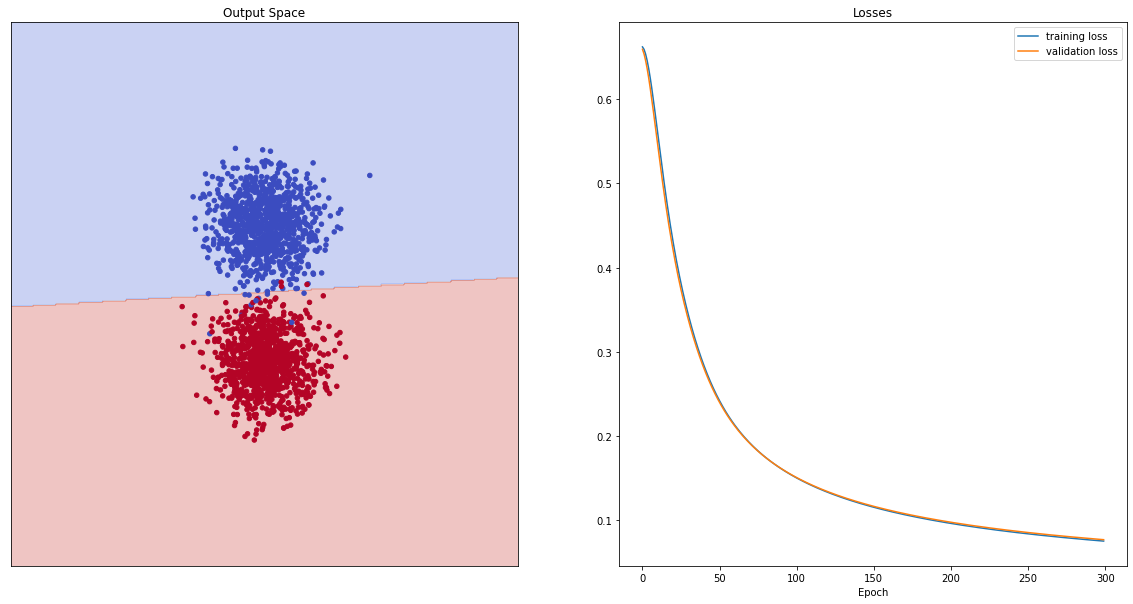

Training: [EPOCH]: 299, [LOSS]: 0.075209, [ACCURACY]: 0.994
Validation: [EPOCH]: 299, [LOSS]: 0.076888, [ACCURACY]: 0.994


In [ ]:
D = 2  # input dimensions
C = 2  # num_classes
H = 100  # num_hidden_units

model = SimpleMLP(D, H, C)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=lambda_l2) # built-in L2

train(criterion, model, optimizer, visualize_surface=True)  

# Lets try with a more complicated dataset

### Run Training

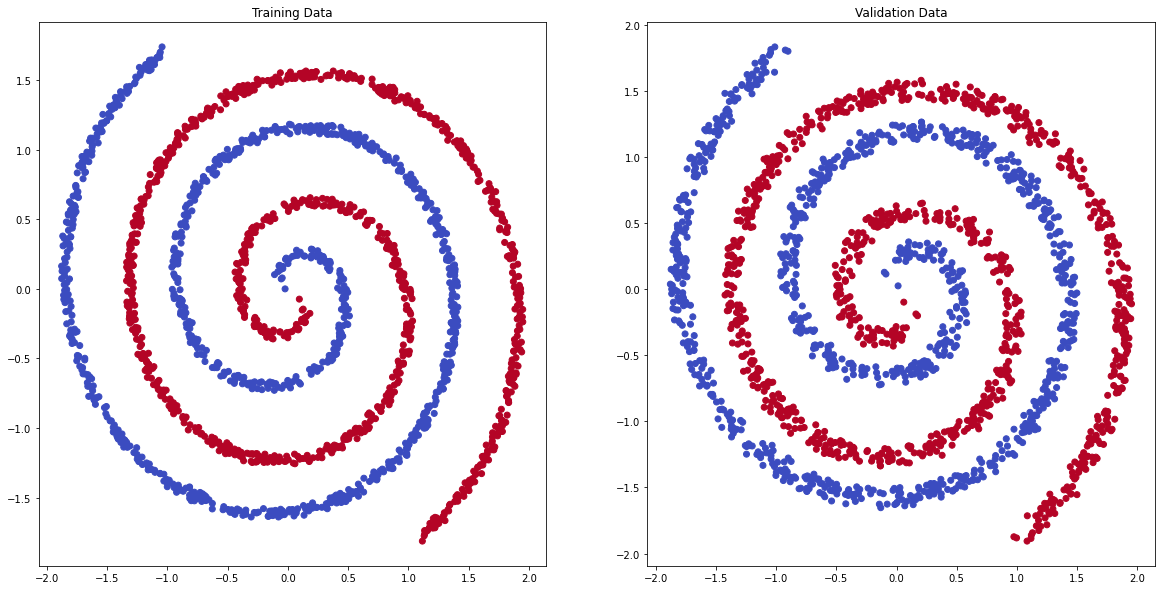

In [ ]:
def make_spiral(n_points, noise=0.5):

    n = np.sqrt(np.random.rand(n_points, 1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points, 1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points, 1) * noise

    x, y = (np.vstack((np.hstack((d1x, d1y)), np.hstack((-d1x + 1, -d1y)))),
            np.hstack((np.zeros(n_points), np.ones(n_points))).astype("int"))

    x = (x - x.mean()) / x.std()

    return x, y

N = 1000 # number of samples
x_train, y_train, x_val, y_val = generate_data(N, make_spiral, noise=0.5)

#Convert the data from numpy arrays into PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train)
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val)

# move data to gpu if available
x_train = x_train.to(device)
y_train = y_train.to(device)

x_val = x_val.to(device)
y_val = y_val.to(device)

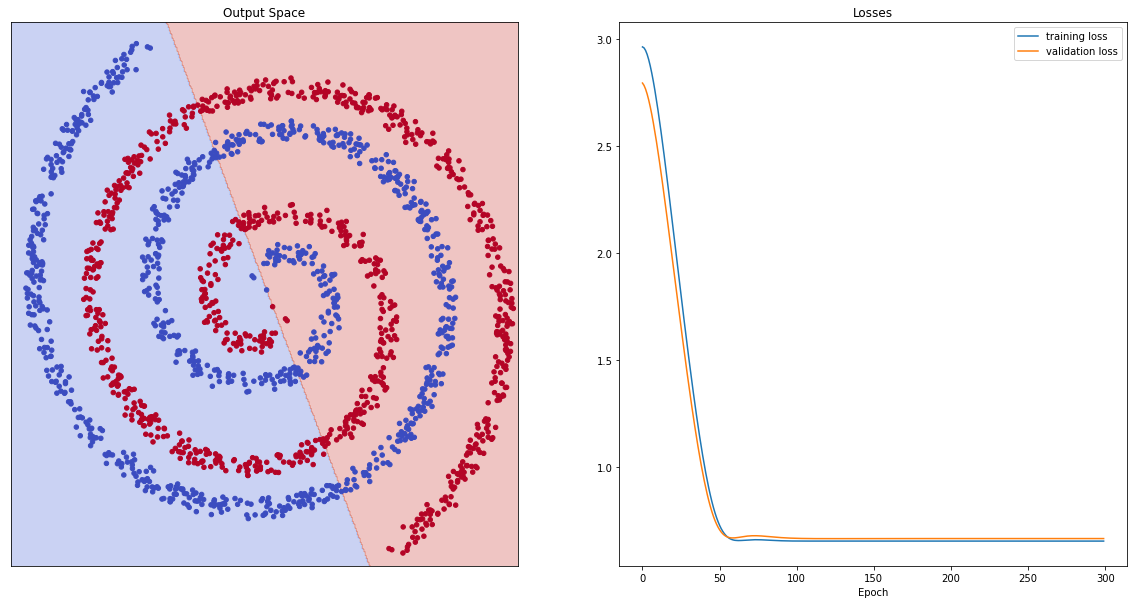

Training: [EPOCH]: 299, [LOSS]: 0.653505, [ACCURACY]: 0.595
Validation: [EPOCH]: 299, [LOSS]: 0.665328, [ACCURACY]: 0.585


In [ ]:
# Run training
# You can set visualize_surface to False to omit the visualization of the output space. The training will be much faster this way
train(criterion, model, optimizer, visualize_surface=True)  

## Excercise 2

Go into [playground.org](https://playground.tensorflow.org/#activation=sigmoid&batchSize=1&dataset=spiral&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=20&networkShape=&seed=0.15655&showTestData=false&discretize=false&percTrainData=60&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false) and play around with its settings to fit the dataset.

He cambiado la activación de 'Sigmoid' a 'Tanh'.
También he añadido una hidden layer de 6 neuronas.
He 'alimentado' el modelo con x1, x2, x1x2, sin(x1) y sin(x2).
Podemos ver que la clasificación no se ajusta al completo, pero no era tampoco el objetivo de este apartado, por lo que me conformo con los resultados obtenidos.
El resultado correcto está en el apartado A del Homework.

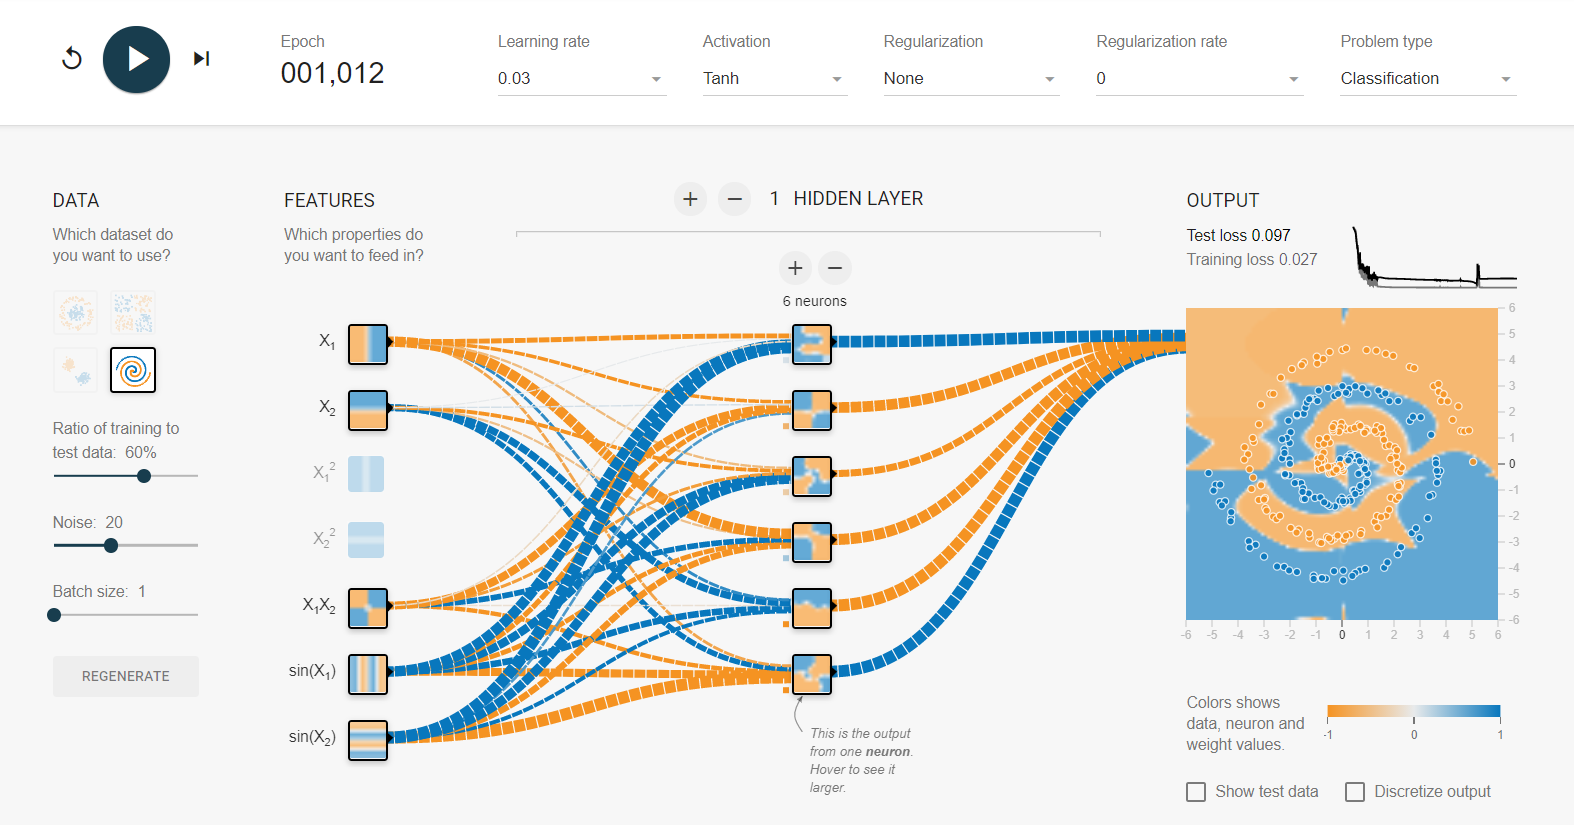

## Excercise 3

Modify the training loop so that learning is done after executing the forward pass on one data point (batch_size of 1). What differences do you observe in the learning process? 

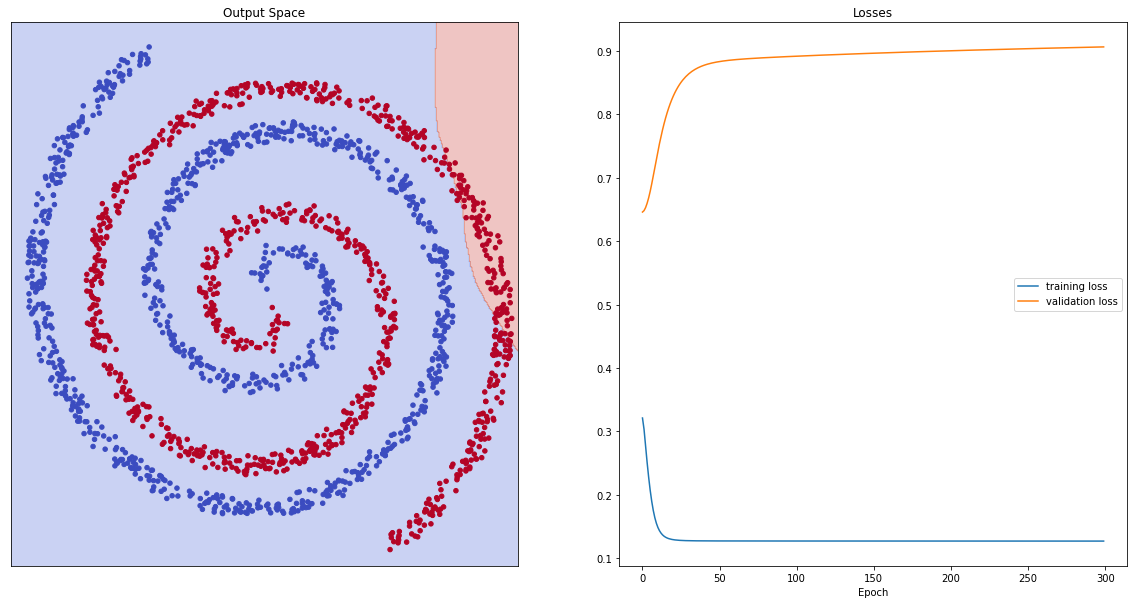

In [ ]:
def validate(criterion, model):

    # set model in evaluation mode
    model.eval()
    with torch.no_grad(): # do not compute gradients for validation
        y_pred = model(x_val)


    # compute loss and accuracy 
    _, predicted = torch.max(y_pred, 1)
    val_loss = criterion(y_pred.squeeze(), y_val)
    val_acc = (y_val == predicted).sum().float() / len(y_val)

    return val_loss, val_acc



# Training loop
def train(criterion, model, optimizer, epochs=300, visualize_surface=False, visualize_regressor=False):
    
    losses = {"train": [], "val": []}

    for t in range(epochs):
        for x, y in zip(x_train, y_train):   #línea añadida
          model.train()
          y_pred = model(x)
          loss = criterion(y_pred.unsqueeze(0), y.unsqueeze(0))   #línea añadida
          losses["train"].append(loss)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          val_loss, val_acc = validate(criterion, model)
          print("Validation: [EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, val_loss.item(), val_acc))
          losses["val"].append(val_loss)
          display.clear_output(wait=True)

          draw_plots(x_val, y_val, model, losses, visualize_surface, visualize_regressor)
          break


train(criterion, model, optimizer, visualize_surface=True)

La gran diferencia que podemos obserbar en el training process es que la curva de loss es puntiaguda y oscila mucho. Esto se debe a que la data que está siendo alimentada no es representativa de la distribución de la data.

### Homework


A) As you can see the model we created is not able to learn a more complex dataset at all. Change the architecture size, the number of neurons the layers, etc and create a model capable of doing so.

In [ ]:
#https://colab.research.google.com/github/Formulator/Spiral/blob/master/PyTorch_Spiral_DataLoader.ipynb#scrollTo=yUcDxSOH2FLT

learning_rate = 0.2

class SimpleMLP(nn.Module):

    def __init__(self, inp_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.pipe = nn.Sequential(
            nn.Linear(inp_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 75),
            nn.ReLU(),
            nn.Linear(75, 50),
            nn.ReLU(),
            nn.Linear(50, output_dim),
            nn.Tanh()
        ).to(device)

    def forward(self, x):
        return self.pipe(x)

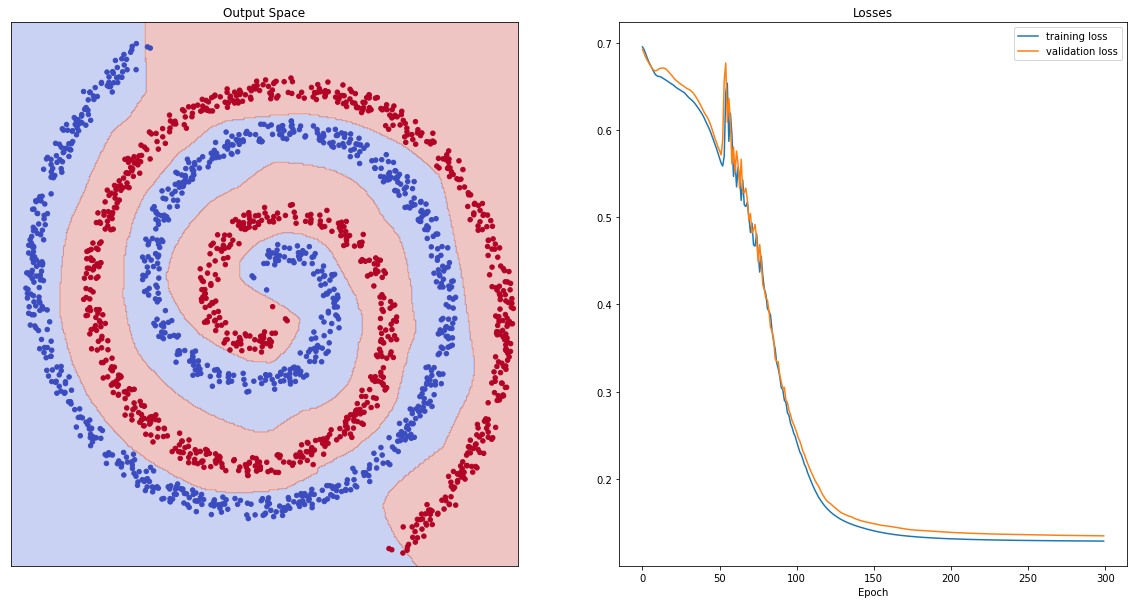

Training: [EPOCH]: 299, [LOSS]: 0.128396, [ACCURACY]: 1.000
Validation: [EPOCH]: 299, [LOSS]: 0.134418, [ACCURACY]: 0.998


In [ ]:
D = 2  # input dimensions
C = 2  # num_classes
H = 100  # num_hidden_units

model = SimpleMLP(D, H, C)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=lambda_l2) # built-in L2

train(criterion, model, optimizer, visualize_surface=True)  

B) Using the data generated in the cell below modify the training code to solve a regression problem.


> Hints


* Note that the generated dataset only has one feature
* You can use the same training and validation functions with some slight modifications since it doesn't make sense to calculate accuracy in a regression problem
* You can find different training criteria (a.k.a loss functions) in PyTorch [docs](https://pytorch.org/docs/stable/nn.html#loss-functions)

In [ ]:
def validate(criterion, model):

    # set model in evaluation mode
    model.eval()
    with torch.no_grad(): # do not compute gradients for validation
        y_pred = model(x_val)

    # compute loss and accuracy 
    _, predicted = torch.max(y_pred, 1)
    val_loss = criterion(y_pred, y_val.unsqueeze(1))

    return val_loss


# Training loop
def train(criterion, model, optimizer, epochs=300, visualize_surface=False, visualize_regressor=False):

    losses = {"train": [], "val": []}

    for t in range(epochs):
        
        # activate training mode
        model.train()
        
        # Feed forward to get the logits
        y_pred = model(x_train.requires_grad_())

        # Compute the loss and accuracy
        loss = criterion(y_pred, y_train)
        losses["train"].append(loss)
        
        # zero the gradients before running
        # the backward pass.
        optimizer.zero_grad()
        
        # Backward pass to compute the gradient
        # of loss w.r.t our learnable params. 
        loss.backward()

        # Update params
        optimizer.step()

        # Run model on validation data
        val_loss = validate(criterion, model)
        losses["val"].append(val_loss)


    plt.plot([c.item() for c in losses['train']])
    plt.plot([c.item() for c in losses['val']])
    plt.legend()

In [ ]:
learning_rate = 0.2

class SimpleMLP(nn.Module):

    def __init__(self, inp_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.pipe = nn.Sequential(
            nn.Linear(inp_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        ).to(device)
    
    def forward(self, x):
        return self.pipe(x)

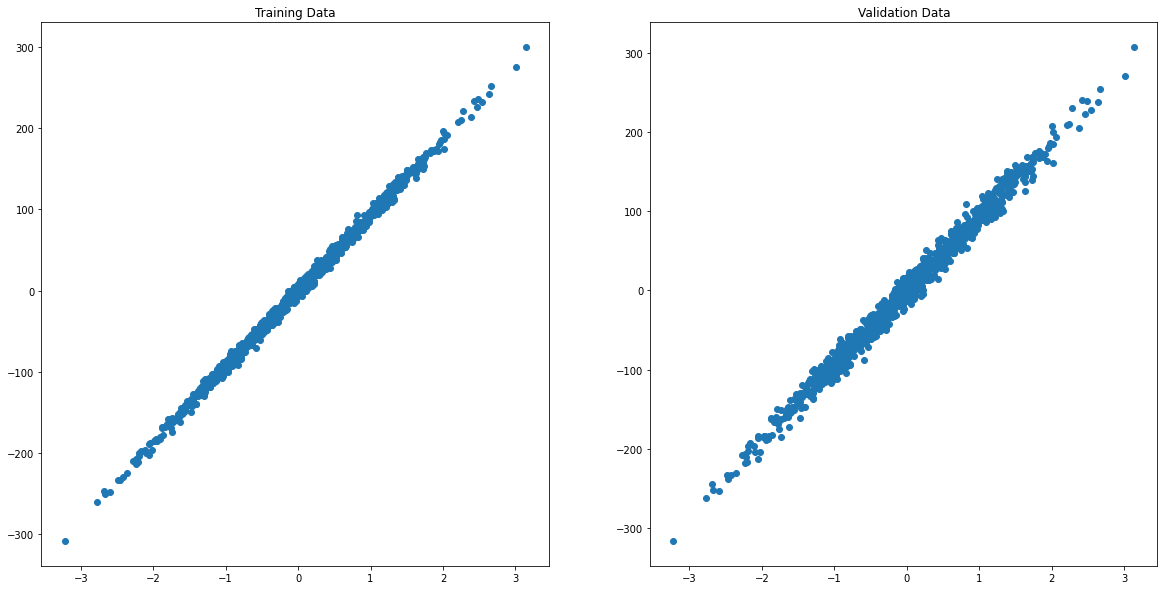

In [ ]:
from sklearn.datasets import make_regression
N = 1000 # number of samples
x_train, y_train, x_val, y_val = generate_data(N, make_regression, regression=True, noise=5, n_features=1, random_state=52)

#Convert the data from numpy arrays into PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

# move data to gpu if available
x_train = x_train.to(device)
y_train = y_train.to(device)

x_val = x_val.to(device)
y_val = y_val.to(device)

y_train = y_train.view(-1,1)
x_train = x_train.view(-1,1)

No handles with labels found to put in legend.


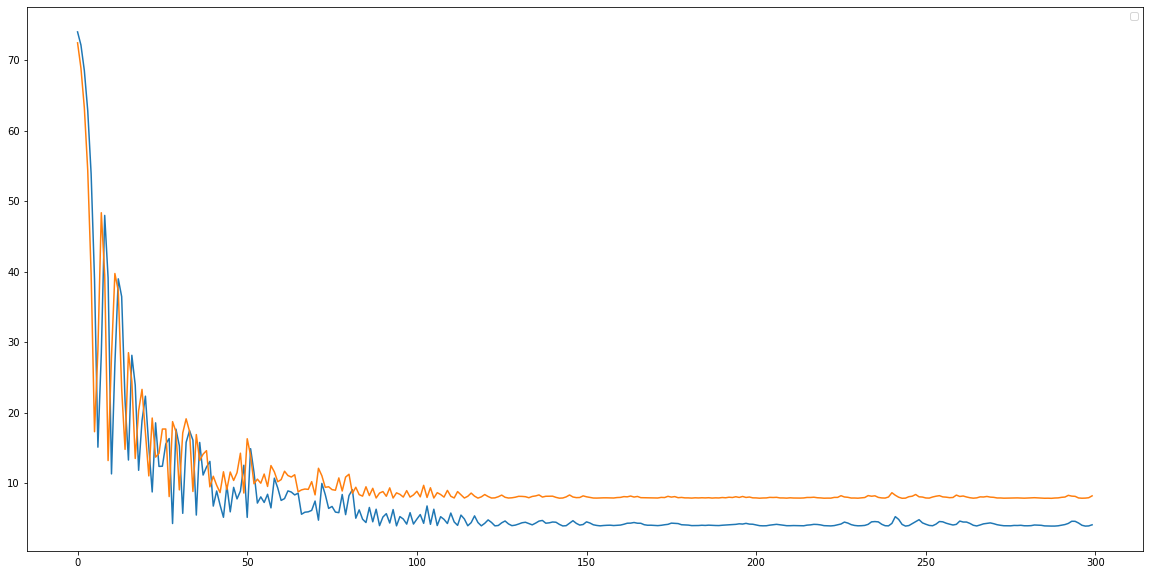

In [ ]:
D = 1  # input dimensions
C = 1  # num_classes
H = 100  # num_hidden_units

model = SimpleMLP(D,H,C)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=lambda_l2) # built-in L2

train(criterion, model, optimizer, visualize_surface=True)  

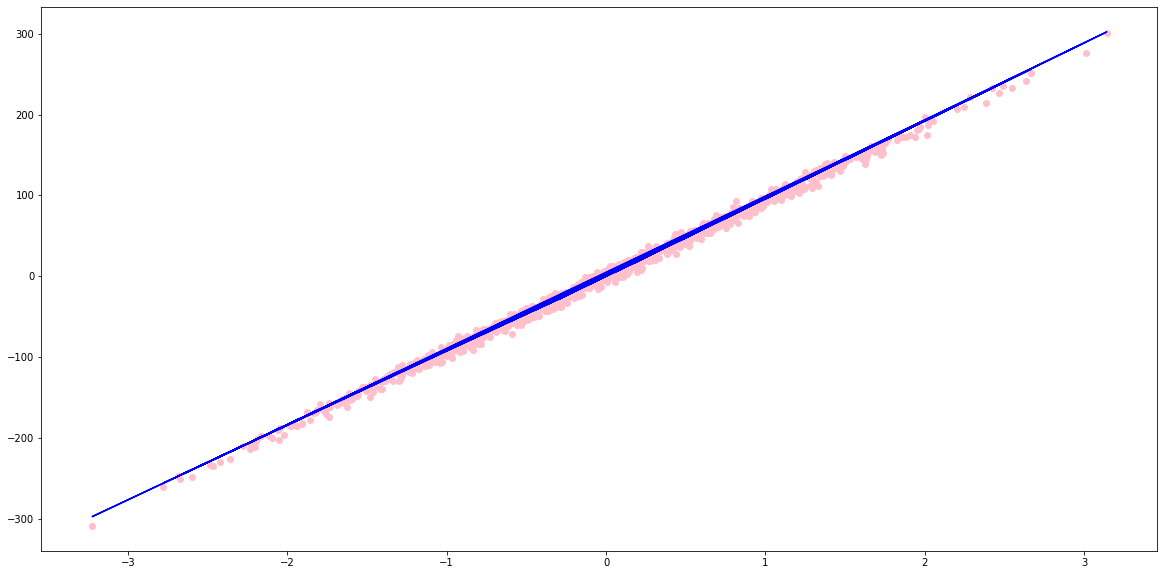

In [ ]:
sol = model(x_train).cpu().detach().numpy()
plt.scatter(x_train.cpu().detach().numpy() , y_train.cpu().detach().numpy(),c="pink")
plt.plot(x_train.cpu().detach().numpy(), sol, c="blue")

### More Homework

C) Using the data generated in the cell below modify the model to tackle a non-binary classification problem



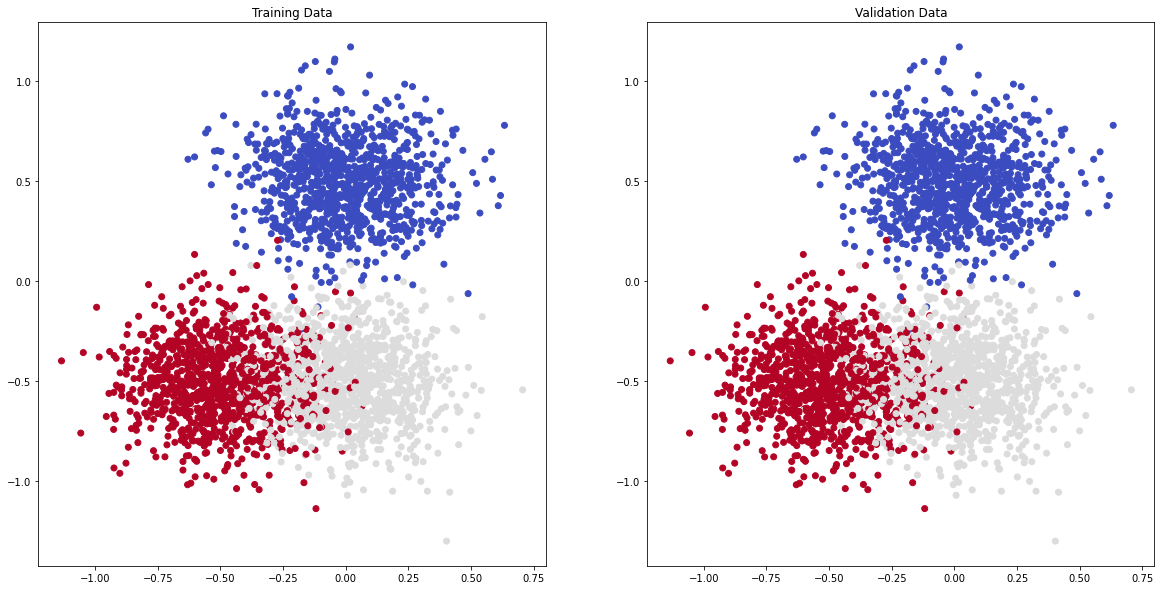

In [ ]:
# find more datasets at https://scikit-learn.org/stable/modules/classes.html#samples-generator
from sklearn.datasets import make_blobs

N = 1000 # number of samples
x_train, y_train, x_val, y_val = generate_data([N, N, N], make_blobs, centers=[[0, 0.5], [0, -0.5], [-0.5, -0.5]], random_state=12, cluster_std=0.2)

#Convert the data from numpy arrays into PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train)
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val)

# move data to gpu if available
x_train = x_train.to(device)
y_train = y_train.to(device)

x_val = x_val.to(device)
y_val = y_val.to(device)

In [ ]:
def validate(criterion, model):   #contrario al modo train

    # set model in evaluation mode
    model.eval()
    with torch.no_grad(): # do not compute gradients for validation
        y_pred = model(x_val)


    # compute loss and accuracy 
    _, predicted = torch.max(y_pred, 1)
    val_loss = criterion(y_pred.squeeze(), y_val)
    val_acc = (y_val == predicted).sum().float() / len(y_val)

    return val_loss, val_acc



# Training loop
def train(criterion, model, optimizer, epochs=300, visualize_surface=False, visualize_regressor=False):
    
    losses = {"train": [], "val": []}

    for t in range(epochs):
        
        # activate training mode
        model.train()
        
        # Feed forward to get the logits
        y_pred = model(x_train)   #se crea el grafo

        
    
        # Compute the loss and accuracy
        loss = criterion(y_pred.squeeze(), y_train)
        score, predicted = torch.max(y_pred, 1)
        train_acc = (y_train == predicted).sum().float() / len(y_train)
        print("Training: [EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), train_acc))
        losses["train"].append(loss)
        
        # zero the gradients before running
        # the backward pass.
        optimizer.zero_grad()   #ponemos las gradientes a 0
        
        # Backward pass to compute the gradient
        # of loss w.r.t our learnable params. 
        loss.backward()   #calculamos los gradientes (derivamos)

        # Update params
        optimizer.step()   #actualizamos los pesos basándose en los gradientes

        # Run model on validation data
        val_loss, val_acc = validate(criterion, model)
        print("Validation: [EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, val_loss.item(), val_acc))
        losses["val"].append(val_loss)

        display.clear_output(wait=True)

        draw_plots(x_val, y_val, model, losses, visualize_surface, visualize_regressor)

    print("Training: [EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), train_acc))
    print("Validation: [EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, val_loss.item(), val_acc))

In [ ]:
class SimpleMLP(nn.Module):

    def __init__(self, inp_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(inp_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
 
    def forward(self, x):
        out = self.fc1(x) 
        return self.fc2(out)

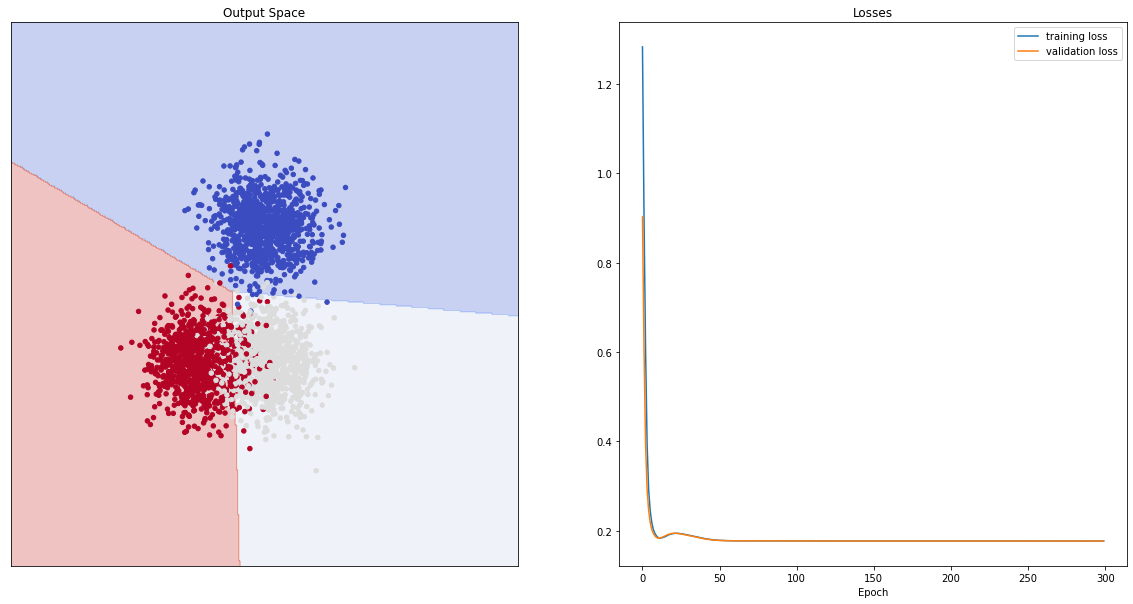

Training: [EPOCH]: 299, [LOSS]: 0.176627, [ACCURACY]: 0.925
Validation: [EPOCH]: 299, [LOSS]: 0.176626, [ACCURACY]: 0.925


In [ ]:
#import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

D = 2  # input dimensions
C = 3  # num_classes
H = 100  # num_hidden_units

model = SimpleMLP(D, H, C)
model.to(device)

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=lambda_l2) # built-in L2
train(criterion, model, optimizer, visualize_surface=True)  

D) Using a Simple Model modify the optimizer to fit the data from question A). Explain the effect of LR, Momentum etc. If you changed the optimizer explain what the  optimizer you chose does and why does it work better or worse.

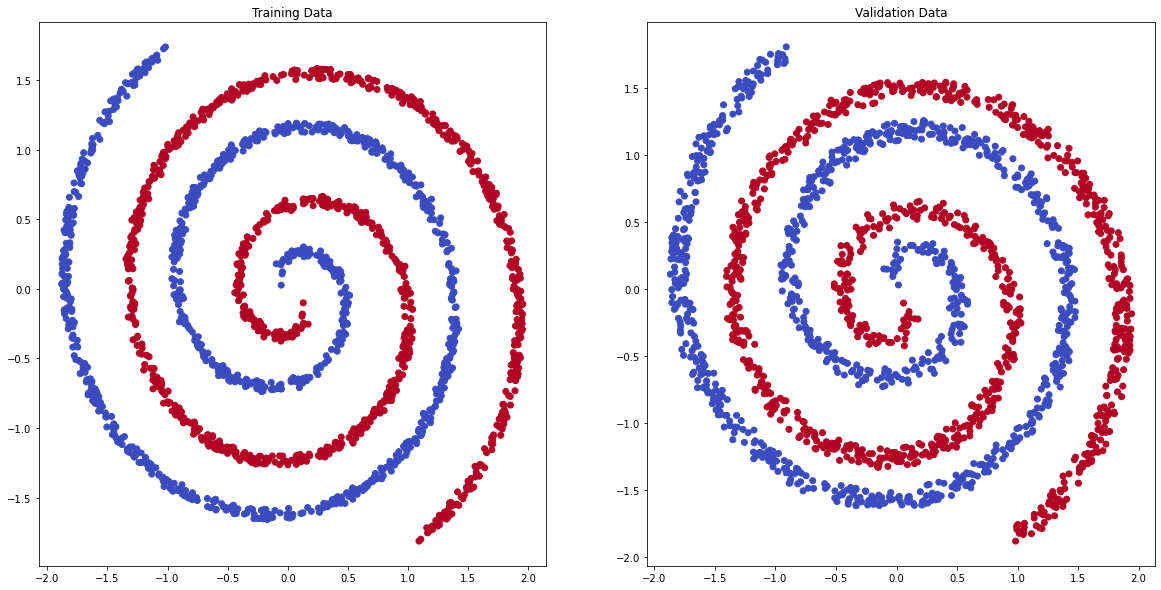

In [ ]:
def make_spiral(n_points, noise=0.5):

    n = np.sqrt(np.random.rand(n_points, 1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points, 1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points, 1) * noise

    x, y = (np.vstack((np.hstack((d1x, d1y)), np.hstack((-d1x + 1, -d1y)))),
            np.hstack((np.zeros(n_points), np.ones(n_points))).astype("int"))

    x = (x - x.mean()) / x.std()

    return x, y

N = 1000 # number of samples
x_train, y_train, x_val, y_val = generate_data(N, make_spiral, noise=0.5)

#Convert the data from numpy arrays into PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train)
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val)

# move data to gpu if available
x_train = x_train.to(device)
y_train = y_train.to(device)

x_val = x_val.to(device)
y_val = y_val.to(device)

In [ ]:
def validate(criterion, model):   #contrario al modo train

    # set model in evaluation mode
    model.eval()
    with torch.no_grad(): # do not compute gradients for validation
        y_pred = model(x_val)


    # compute loss and accuracy 
    _, predicted = torch.max(y_pred, 1)
    val_loss = criterion(y_pred.squeeze(), y_val)
    val_acc = (y_val == predicted).sum().float() / len(y_val)

    return val_loss, val_acc



# Training loop
def train(criterion, model, optimizer, epochs=300, visualize_surface=False, visualize_regressor=False):
    
    losses = {"train": [], "val": []}

    for t in range(epochs):
        
        # activate training mode
        model.train()
        
        # Feed forward to get the logits
        y_pred = model(x_train)   #se crea el grafo
    
        # Compute the loss and accuracy
        loss = criterion(y_pred.squeeze(), y_train)
        score, predicted = torch.max(y_pred, 1)
        train_acc = (y_train == predicted).sum().float() / len(y_train)
        print("Training: [EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), train_acc))
        losses["train"].append(loss)
        
        # zero the gradients before running
        # the backward pass.
        optimizer.zero_grad()   #ponemos las gradientes a 0
        
        # Backward pass to compute the gradient
        # of loss w.r.t our learnable params. 
        loss.backward()   #calculamos los gradientes (derivamos)

        # Update params
        optimizer.step()   #actualizamos los pesos basándose en los gradientes

        # Run model on validation data
        val_loss, val_acc = validate(criterion, model)
        print("Validation: [EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, val_loss.item(), val_acc))
        losses["val"].append(val_loss)

        display.clear_output(wait=True)

        draw_plots(x_val, y_val, model, losses, visualize_surface, visualize_regressor)

    print("Training: [EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), train_acc))
    print("Validation: [EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, val_loss.item(), val_acc))

In [ ]:
#https://colab.research.google.com/github/Formulator/Spiral/blob/master/PyTorch_Spiral_DataLoader.ipynb#scrollTo=yUcDxSOH2FLT
class SimpleMLP(nn.Module):

    def __init__(self, inp_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.pipe = nn.Sequential(
            nn.Linear(inp_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 75),
            nn.ReLU(),
            nn.Linear(75, 50),
            nn.ReLU(),
            nn.Linear(50, output_dim),
            nn.Tanh()
        ).to(device)

    def forward(self, x):
        return self.pipe(x)

* LR = 0.01
* MOMENTUM = 0.1

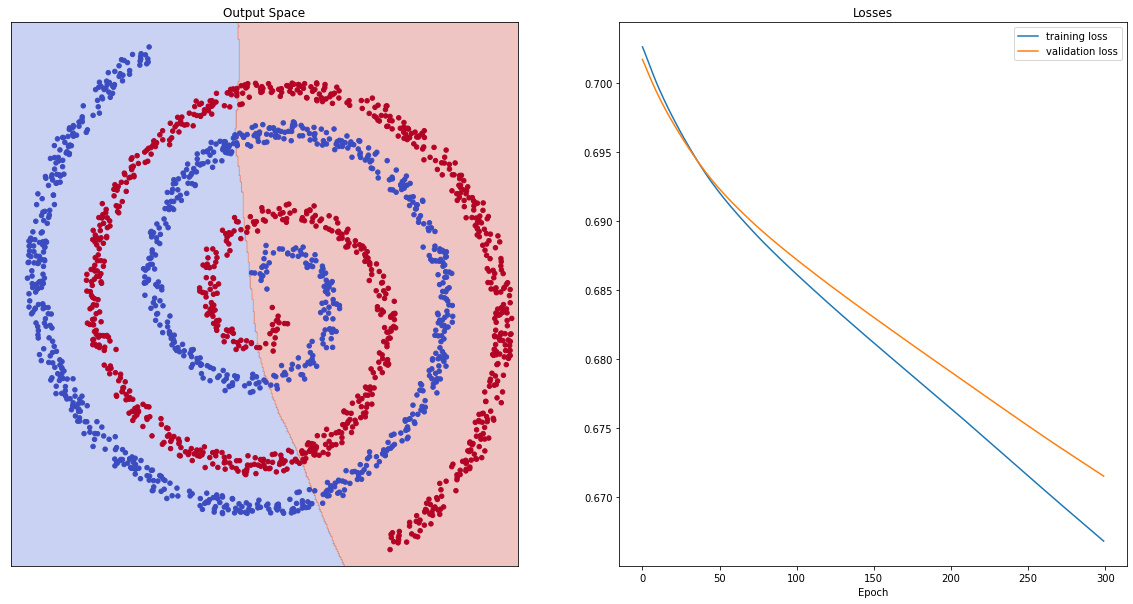

Training: [EPOCH]: 299, [LOSS]: 0.666836, [ACCURACY]: 0.593
Validation: [EPOCH]: 299, [LOSS]: 0.671541, [ACCURACY]: 0.588


In [ ]:
D = 2  # input dimensions
C = 2  # num_classes
H = 100  # num_hidden_units

model = SimpleMLP(D, H, C)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.1, weight_decay=lambda_l2) # built-in L2
criterion = torch.nn.CrossEntropyLoss()
train(criterion, model, optimizer, visualize_surface=True)  

* LR = 0.2
* MOMENTUM = 0.1

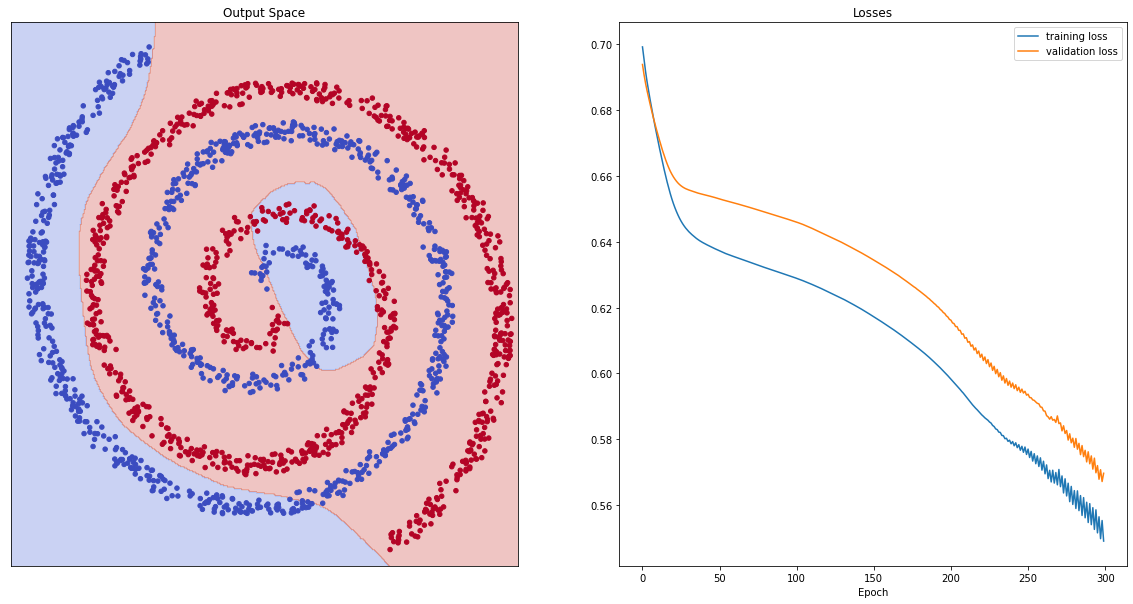

Training: [EPOCH]: 299, [LOSS]: 0.549030, [ACCURACY]: 0.704
Validation: [EPOCH]: 299, [LOSS]: 0.569642, [ACCURACY]: 0.701


In [ ]:
D = 2  # input dimensions
C = 2  # num_classes
H = 100  # num_hidden_units

model = SimpleMLP(D, H, C)

optimizer = torch.optim.SGD(model.parameters(), lr=0.2, momentum=0.1, weight_decay=lambda_l2) # built-in L2
criterion = torch.nn.CrossEntropyLoss()
train(criterion, model, optimizer, visualize_surface=True)  

* LR = 0.01
* MOMENTUM = 0.9

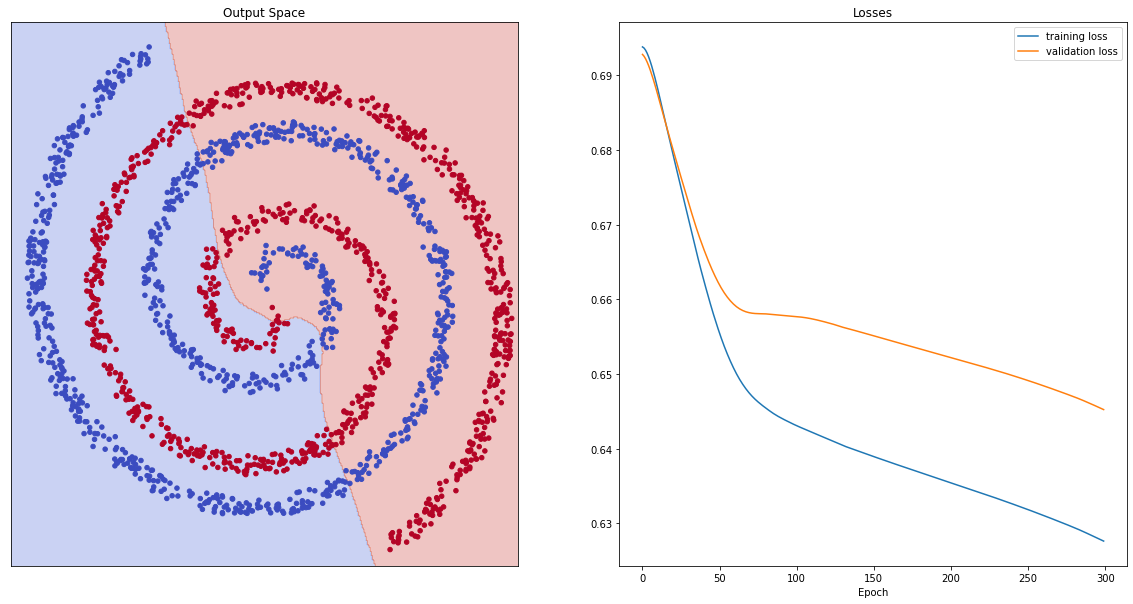

Training: [EPOCH]: 299, [LOSS]: 0.627611, [ACCURACY]: 0.618
Validation: [EPOCH]: 299, [LOSS]: 0.645226, [ACCURACY]: 0.599


In [ ]:
D = 2  # input dimensions
C = 2  # num_classes
H = 100  # num_hidden_units

model = SimpleMLP(D, H, C)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=lambda_l2) # built-in L2
criterion = torch.nn.CrossEntropyLoss()
train(criterion, model, optimizer, visualize_surface=True)  

* LR = 0.2
* MOMENTUM = 0.9

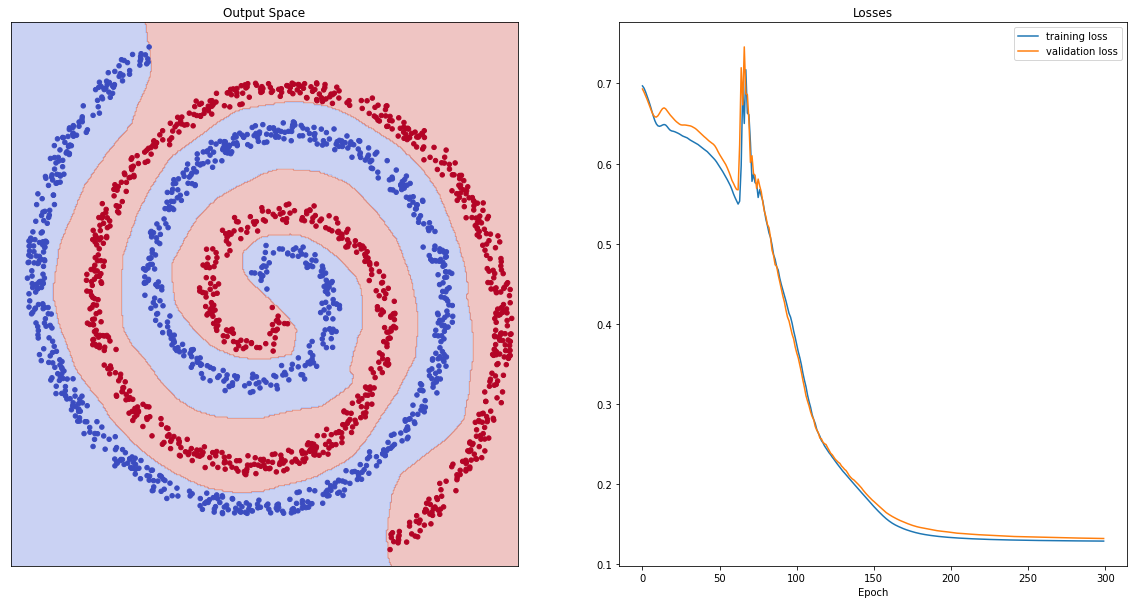

Training: [EPOCH]: 299, [LOSS]: 0.129002, [ACCURACY]: 0.999
Validation: [EPOCH]: 299, [LOSS]: 0.132224, [ACCURACY]: 1.000


In [ ]:
D = 2  # input dimensions
C = 2  # num_classes
H = 100  # num_hidden_units

model = SimpleMLP(D, H, C)

optimizer = torch.optim.SGD(model.parameters(), lr=0.2, momentum=0.9, weight_decay=lambda_l2) # built-in L2
criterion = torch.nn.CrossEntropyLoss()
train(criterion, model, optimizer, visualize_surface=True)  

* LR = 0.4
* MOMENTUM = 0.9

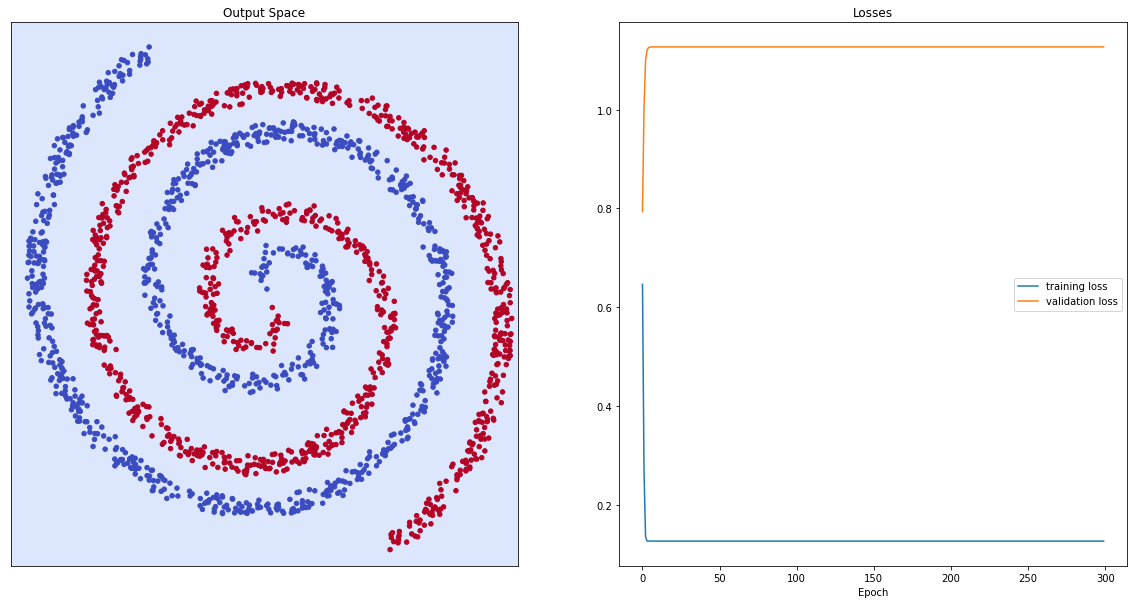

In [ ]:
D = 2  # input dimensions
C = 2  # num_classes
H = 100  # num_hidden_units

model = SimpleMLP(D, H, C)

optimizer = torch.optim.SGD(model.parameters(), lr=0.4, momentum=0.9, weight_decay=lambda_l2) # built-in L2
criterion = torch.nn.CrossEntropyLoss()
train(criterion, model, optimizer, visualize_surface=True)  

* LR = 0.6
* MOMENTUM = 0.9

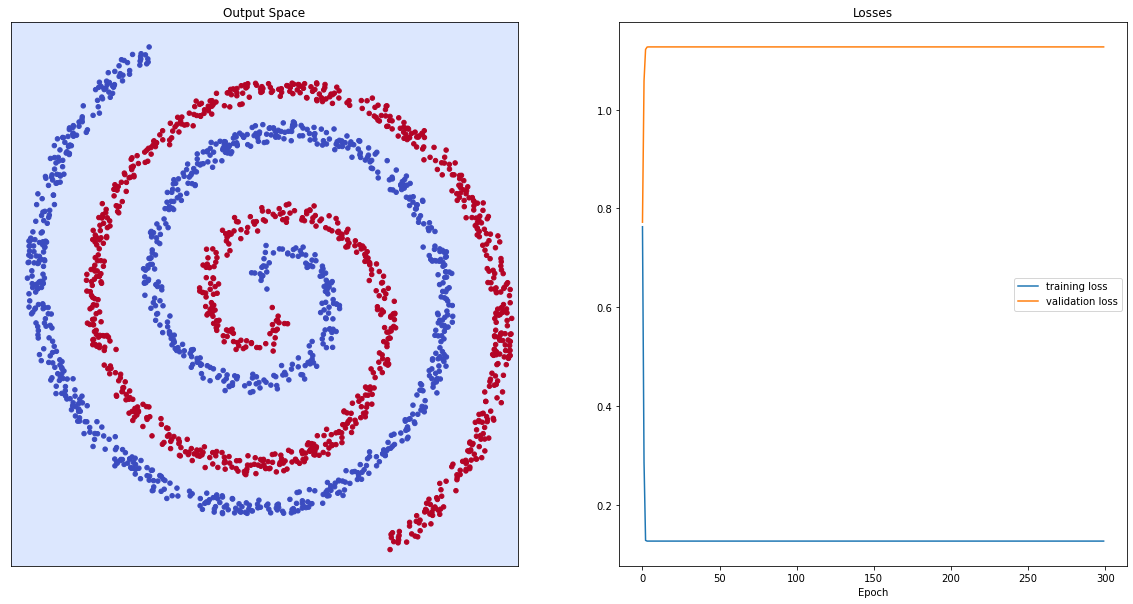

In [ ]:
D = 2  # input dimensions
C = 2  # num_classes
H = 100  # num_hidden_units

model = SimpleMLP(D, H, C)

optimizer = torch.optim.SGD(model.parameters(), lr=0.6, momentum=0.9, weight_decay=lambda_l2) # built-in L2
criterion = torch.nn.CrossEntropyLoss()
train(criterion, model, optimizer, visualize_surface=True)  

Learning rate (=tasa de aprendizaje): parámetro que determina el **tamaño del paso** en cada iteración mientras llegamos al mínimo en la función de loss. Representa la velocidad a la que nuestro modelo "aprende". Por ejemplo, un **learning rate de 0.1** significa que solo **avanzamos un 10%** (hacia la dirección indicada) **de la distancia obtenida**.
De este modo, si es de un valor muy bajo necesitarmos muchísimos 'epochs' para convergir.

Momentum = intento de mantener una dirección consistente. Si estamos dando pasos más pequeños, también tiene sentido **mantener un rumbo algo consistente a través de nuestro espacio**; este es el objetivo del momentum. Por ejemplo, si tenemos un **momentum de 0.9, tomaremos el 90% de la dirección anterior más el 10% de la nueva dirección** y ajustaremos los pesos en consecuencia.

En nuestro ejemplo 'elipse', nos beneficia tomar un momentum muy elevado (de 0.9) y un learning rate estándar (0.2). De este modo nuestro modelo va a mantener un rumbo muy consistente, mientras avanzamos poco a poco.